<a href="https://colab.research.google.com/github/pacomm5/COVID-19/blob/master/cluster_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
# Importing libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# Hide unnecessary warnings
import warnings
warnings.filterwarnings('ignore')
# Clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
pd.plotting.register_matplotlib_converters()
import math
from matplotlib import gridspec

In [2]:
# con esto clonamos el github. tarda un rato mas menos 10 minutos. Entiendo que no ocupa memoria 

!git clone https://github.com/CSSEGISandData/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 281908, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 281908 (delta 24), reused 37 (delta 19), pack-reused 281866
Receiving objects: 100% (281908/281908), 3.41 GiB | 12.83 MiB/s, done.
Resolving deltas: 100% (225768/225768), done.
Checking out files: 100% (1640/1640), done.


Cada fila representa un área FIPS en una provincia/estado de los Estados Unidos. Las columnas contienen el aumento acumulado de muertes por COVID-19 del 22 de enero de 2020 al 6 de junio de 2020.

In [34]:
# importamos los datos 
data = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
data.head()


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,12/28/21,12/29/21,12/30/21,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22,1/10/22,1/11/22,1/12/22,1/13/22,1/14/22,1/15/22,1/16/22,1/17/22,1/18/22,1/19/22,1/20/22,1/21/22,1/22/22,1/23/22,1/24/22,1/25/22,1/26/22,1/27/22,1/28/22,1/29/22,1/30/22,1/31/22,2/1/22,2/2/22,2/3/22,2/4/22,2/5/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",55869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,160,160,160,160,160,160,160,161,161,161,162,162,162,162,162,162,162,162,162,163,163,163,163,163,163,163,163,163,165,163,163,166,166,166,166,167,168,168,170,170
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",223234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,593,593,593,593,593,593,593,594,594,598,601,603,603,603,603,603,603,603,603,605,605,605,605,607,608,608,608,608,610,608,608,612,612,612,612,614,616,616,623,623
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",24686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,81,81,81,81,81,81,81,81,81,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,84,83,83,84,84,84,84,84,85,85,85,85
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",22394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,96,96,96,96,96,96,96,96
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",57826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,197,198,198,198,198,198,198,198,198,198,199,202,202,202,202,202,202,202,202,203,203,203,203,204,204,204,204,204,206,204,204,207,207,207,207,207,208,208,210,210


Para examinar los datos, primero creamos datos agregados de series temporales a nivel de país.

In [35]:
us_ts = data.iloc[:,12:] # con esto sacamos todas las fechas, y los datos que contienen
us_ts = pd.DataFrame(us_ts.sum(axis=0)).reset_index() # con esto convertimos las columnas fechas a filas, y las ponemos como index. 
us_ts.columns = ["Date","NoOfCases"] # ponemos los nombres a las columnas 
us_ts["Date"] = pd.to_datetime(us_ts["Date"]) # convertimos la fecha a formato fecha. 
us_ts.set_index('Date', inplace=True)
us_ts.tail()

,NoOfCases
Date,
2022-02-01,891450
2022-02-02,894996
2022-02-03,897237
2022-02-04,901391
2022-02-05,902266


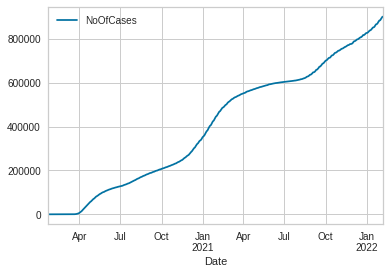

In [36]:
us_ts.plot()

ahora creamos los datos de series temporales por estado

In [58]:
data_by_state = data.groupby("Province_State").agg(sum).reset_index() # Data grouped by states to create clusters at state level
data_by_state = data_by_state.drop(columns=["UID", "code3", "FIPS", "Lat", "Long_", "Population"]) # quitamos todas estas columnas. 
data_by_state.head()

,Province_State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,12/28/21,12/29/21,12/30/21,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22,1/10/22,1/11/22,1/12/22,1/13/22,1/14/22,1/15/22,1/16/22,1/17/22,1/18/22,1/19/22,1/20/22,1/21/22,1/22/22,1/23/22,1/24/22,1/25/22,1/26/22,1/27/22,1/28/22,1/29/22,1/30/22,1/31/22,2/1/22,2/2/22,2/3/22,2/4/22,2/5/22
0,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,16436,16454,16455,16455,16455,16455,16455,16496,16503,16543,16585,16624,16624,16624,16630,16641,16641,16641,16641,16734,16734,16734,16756,16792,16824,16826,16826,16826,16914,16826,16826,17047,17086,17086,17086,17146,17215,17215,17371,17371
1,Alaska,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,976,978,978,978,978,978,979,979,979,979,980,980,980,980,980,985,985,987,987,987,987,987,1051,1051,1051,1051,1051,1072,1072,1081,1081,1085,1085,1085,1085,1085,1093,1093,1093,1093
2,American Samoa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arizona,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,23982,24144,24171,24229,24354,24355,24355,24509,24570,24586,24616,24704,24773,24773,24986,24992,25002,25068,25068,25171,25212,25395,25416,25429,25502,25557,25623,25624,25624,25899,25932,26001,26183,26206,26205,26345,26369,26430,26530,26628
4,Arkansas,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9097,9113,9131,9148,9180,9196,9221,9248,9256,9278,9298,9314,9314,9333,9358,9372,9390,9413,9430,9434,9437,9452,9462,9470,9484,9498,9510,9532,9556,9574,9596,9616,9616,9616,9628,9667,9690,9733,9762,9793


#Modelo de Agrupación de series temporales.

Ahora vamos a utilizar el algoritmo de agrupación KMeans para desarrollar un modelo de agrupación en los datos de series temporales de muertes a nivel estatal. La agrupación de KMeans es un algoritmo de aprendizaje no supervisado para agrupar elementos en clústeres k. Cada elemento se coloca en su clúster más cercano en k-means. Se calculan los centros del clúster, como media de los miembros del clúster. Este procedimiento se realiza repetidamente hasta que el centro se estabiliza. La noción básica del algoritmo del clúster k-means es la siguiente: los resultados se producen en dos partes: primero los centros del clúster se generan como salida y luego cada entidad se asigna a un clúster específico. El cúmulo más cercano generalmente depende de la distancia desde Euclidea, pero también se utilizan otras mediciones de distancia (p. ej. Manhattan, distancia de Minkowski). El procedimiento k-means se ejecuta iterativamente hasta que se logra la condición de terminación especificada (por ejemplo, los centros se mueven menos de 1e-10).

## Primero elegimos el número de clusteres

En la agrupación de KMeans, el número de clústeres que se formarán debe especificarse antes de los cálculos. Podemos usar la clase KElbowVisualizer en el paquete yellowbrick para encontrar este número óptimo. El KElbowVisualizer aplica el método "codo" para ayudar a los científicos de datos a seleccionar el número óptimo de clústeres ajustando el modelo con un rango de valores K. Si el diagrama parece un brazo, el "codo" (el punto de inflexión en la curva) es una buena indicación de que el subyacente de la mejor alineación del modelo subordinado. El "Codo" en el visualizador está marcado con una línea discontinua.

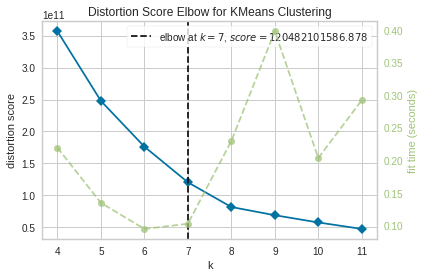

In [59]:
model = KMeans(init='k-means++') # esto crea el modelo
visualizer = KElbowVisualizer(model, k=(4,12),metric="distortion") # establecemos un rango de Kluster de 4 a 12  
visualizer.fit(data_by_state.iloc[:,1:]) 
visualizer.show()
# del dibujo sacamos que el numero de clusters es 7

## Ajuste del algoritmo K-means

Al especificar n_clusters=7, ajustamos el modelo de agrupación KMeans con el número óptimo de clústeres y asignamos el número de clúster a cada estado individual.

In [60]:
# Clustering with 7 clusters
kmeans = KMeans(n_clusters=7,init='k-means++',random_state=0)  
y_kmeans = kmeans.fit_predict(data_by_state.iloc[:,1:])  
data_by_state["Cluster"] = y_kmeans

## distribución de clusters

In [63]:
for i in range(1,6):
    print("States in cluster {} are {}".format(i,list(data_by_state[data_by_state.Cluster==i]["Province_State"].unique())))

States in cluster 1 are ['California', 'Texas']
States in cluster 2 are ['Georgia', 'Illinois', 'Michigan', 'New Jersey', 'Ohio', 'Pennsylvania']
States in cluster 3 are ['Alaska', 'American Samoa', 'Delaware', 'Diamond Princess', 'District of Columbia', 'Grand Princess', 'Guam', 'Hawaii', 'Idaho', 'Maine', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'Northern Mariana Islands', 'Oregon', 'Puerto Rico', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virgin Islands', 'West Virginia', 'Wyoming']
States in cluster 4 are ['New York']
States in cluster 5 are ['Alabama', 'Arizona', 'Indiana', 'Louisiana', 'Massachusetts', 'Missouri', 'North Carolina', 'South Carolina', 'Tennessee', 'Virginia']


Creamos las etiquetas del cluster. 

In [64]:
cluster_labels =['Cluster0 - Other', 'Cluster1 - NY', 'Cluster2 - CA-CT-LA', 'Cluster3 - IL, MA, MI, PA','Cluster4 - CO-FL-GA-IN-MD-OH-TX-VA-WA', 'Cluster5 - NJ']

## visualización de clusters

Visualizar estos clústeres puede ayudar a comprender mejor las similitudes de los clústeres. Una buena manera de visualizar estos cúmulos es trazar una serie temporal agregada con el número promedio de muertes de todos los estados en el cúmulo asignado diariamente con un intervalo de confianza del 95%

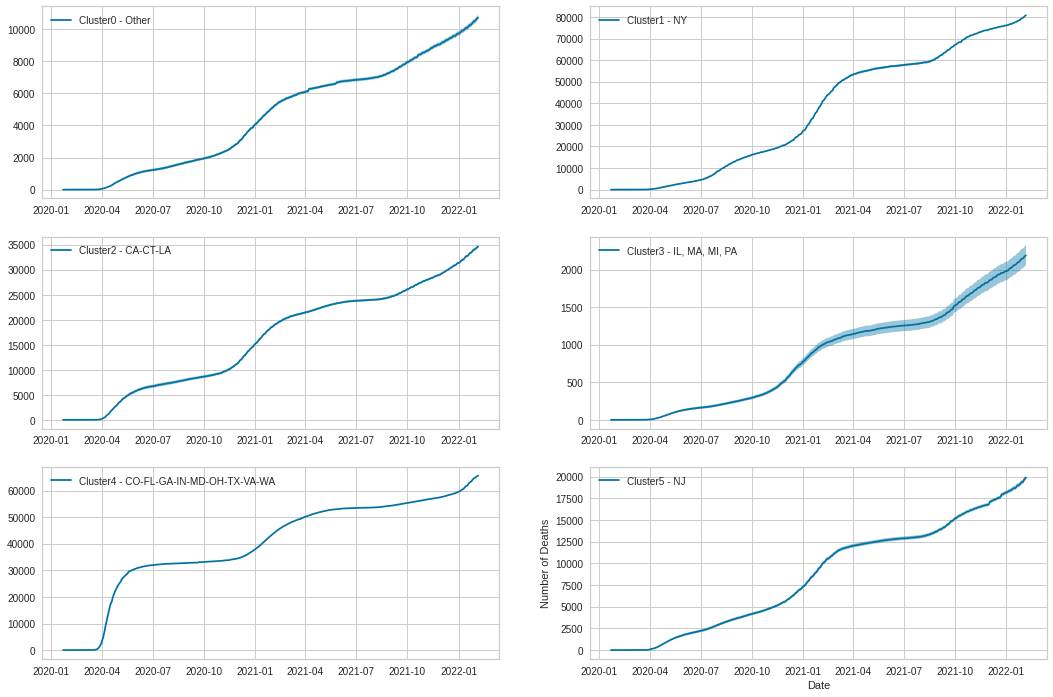

In [71]:
## For generating 95% confidence interval 
def get_cluster_intervals(cluster):
    df = pd.DataFrame() 
    df["mean"] = cluster.mean(axis=0)
    df["lower_bound"] = df["mean"] - (1.96 * cluster.std(axis=0))/np.sqrt(len(df["mean"]))
    df["upper_bound"] = df["mean"] + (1.96 * cluster.std(axis=0))/np.sqrt(len(df["mean"]))
    df.index = us_ts.index
    return df
clusters = [get_cluster_intervals(data_by_state[data_by_state["Cluster"]==n].iloc[:,1:-1]) for n in range(6)]
K = 6
cols = 2
rows = int(math.ceil(K / cols))
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure( figsize=(18, 12))
for n in range(K):
    ax = fig.add_subplot(gs[n])
    ax.plot(clusters[n].index,clusters[n]["mean"],label=cluster_labels[n])
    ax.fill_between(clusters[n].index, clusters[n]["lower_bound"], clusters[n]["upper_bound"], alpha=.4)
    plt.legend()
    
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.show()
fig.tight_layout()